<a href="https://colab.research.google.com/github/xcalibur215/garbage_type_classifier/blob/main/garbage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/Xcalibur/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5


In [2]:
import matplotlib.pyplot as plt
from PIL import Image

import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split

In [3]:
full_dataset = ImageFolder(os.path.join(path, 'Garbage_Dataset_Classification/images'), transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))

In [4]:
full_dataset.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [5]:
input_size = (224, 224)

train_transform = v2.Compose([
    v2.Resize(input_size),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.GaussianNoise(mean=0.1),
    v2.RandomRotation(degrees=30),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

test_transform = v2.Compose([
    v2.Resize(input_size),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

/Users/Xcalibur/miniforge3/envs/deeplearn/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
batch_size = 32

train_size = int(0.7 * (len(full_dataset)))
test_size = int(len(full_dataset)) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
sample_batch = next(iter(train_loader))
print(f' Sample image size: {sample_batch[0].shape}')
print(f' Sample label size: {sample_batch[1].shape}')

 Sample image size: torch.Size([32, 3, 224, 224])
 Sample label size: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.622571].


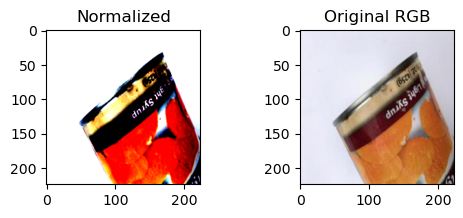

In [8]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

idx = np.random.randint(0, batch_size)

plt.figure(figsize=(6,2))
plt.subplot(1, 2, 1)
plt.title(f"Normalized")
normalized_img = sample_batch[0][idx].permute(1, 2, 0).numpy()
plt.imshow(normalized_img)

plt.subplot(1, 2, 2)
plt.title(f"Original RGB")
original_tensor = denormalize(sample_batch[0][idx].clone())
original_rgb_tensor = torch.clamp(original_tensor.permute(1, 2, 0), 0, 1).numpy()
plt.imshow(original_rgb_tensor)

In [9]:
model = nn.Sequential(
    # Block 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.25),

    # Block 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.3),

    # Block 3
    nn.Conv2d(64, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.35),

    # Global pooling
    nn.AdaptiveAvgPool2d((4, 4)),
    nn.Flatten(),

    # FC
    nn.Linear(256 * 4 * 4, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.Linear(128, 6)
)


dummy_input = torch.randn(2, 3, 224, 224) #batchnorm2d
print(model(dummy_input).shape)

torch.Size([2, 6])


In [10]:
from torchsummary import summary

# Display model summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
         Dropout2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,496
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

In [11]:
epochs = 10
lr = 0.001
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
import torch
from tqdm import tqdm

# Device setup
device = 'cuda' if torch.cuda.is_available() else (
    'mps' if torch.backends.mps.is_available() else 'cpu'
)

#moving to gpu
model = model.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)


for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for image, label in tqdm(train_loader, desc=f"Train Epoch {epoch}/{epochs}", leave=False):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(image)                      # [batch_size, num_classes]
        loss = loss_fn(output, label)              # label: [batch_size]
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * image.size(0)
        train_correct += (output.argmax(1) == label).sum().item()
        train_total += label.size(0)

    avg_train_loss = train_loss / train_total
    avg_train_acc = train_correct / train_total

    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.inference_mode():
        for image, label in tqdm(test_loader, desc=f"Eval Epoch {epoch}/{epochs}", leave=False):
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item() * image.size(0)
            test_correct += (output.argmax(1) == label).sum().item()
            test_total += label.size(0)

    avg_test_loss = test_loss / test_total
    avg_test_acc = test_correct / test_total
    
    print(
        f"Epoch {epoch}: "
        f"Train Loss {avg_train_loss:.6f}, Train Acc {avg_train_acc*100:.2f}% | "
        f"Eval Loss {avg_test_loss:.6f}, Eval Acc {avg_test_acc*100:.2f}%"
    )

KeyboardInterrupt: 

In [ ]:
full_dataset.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}